Импорт библиотек

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
data = pd.read_json('data.json')

Посмотрим на полученный датасет. Он содержит 3 колонки:
id блюда - в данном случае неинформативная колонка
Название кухни, из которой исходит блюдо - наша целевая переменная
Ингридиенты, из которых состоит блюдо - данные в формате списка

In [ ]:
data

,id,cuisine,ingredients
0,10259,greek,"[romaine lettuce, black olives, grape tomatoes..."
1,25693,southern_us,"[plain flour, ground pepper, salt, tomatoes, g..."
2,20130,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, g..."
3,22213,indian,"[water, vegetable oil, wheat, salt]"
4,13162,indian,"[black pepper, shallots, cornflour, cayenne pe..."
...,...,...,...
39769,29109,irish,"[light brown sugar, granulated sugar, butter, ..."
39770,11462,italian,"[KRAFT Zesty Italian Dressing, purple onion, b..."
39771,2238,irish,"[eggs, citrus fruit, raisins, sourdough starte..."
39772,41882,chinese,"[boneless chicken skinless thigh, minced garli..."


Размер датафрейма(пригодится в дальнейшем)

In [ ]:
shape = data.shape
shape

(39774, 3)

Исследуем популярность разных кухонь в имеющемся датасете

In [ ]:
top_cuisines = data['cuisine'].value_counts()

In [ ]:
top_cuisines

italian         7838
mexican         6438
southern_us     4320
indian          3003
chinese         2673
french          2646
cajun_creole    1546
thai            1539
japanese        1423
greek           1175
spanish          989
korean           830
vietnamese       825
moroccan         821
british          804
filipino         755
irish            667
jamaican         526
russian          489
brazilian        467
Name: cuisine, dtype: int64

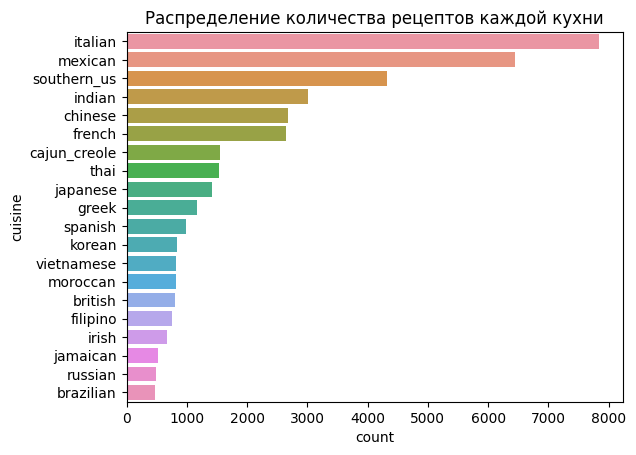

In [ ]:
plt.title('Распределение количества рецептов каждой кухни')
sns.countplot(data, y='cuisine', order=top_cuisines.index);

Посмотрим, какие ингридиенты являются самыми популярными для каждой кухни

In [ ]:
my_dict = {cuisine_name:dict() for cuisine_name in top_cuisines.index}

In [ ]:
for i in range(shape[0]):
  cuisine = data['cuisine'][i]
  ingredients = data['ingredients'][i]
  for ingredient in ingredients:
    if ingredient in my_dict[cuisine].keys():
      my_dict[cuisine][ingredient] += 1
    else:
      my_dict[cuisine][ingredient] = 1


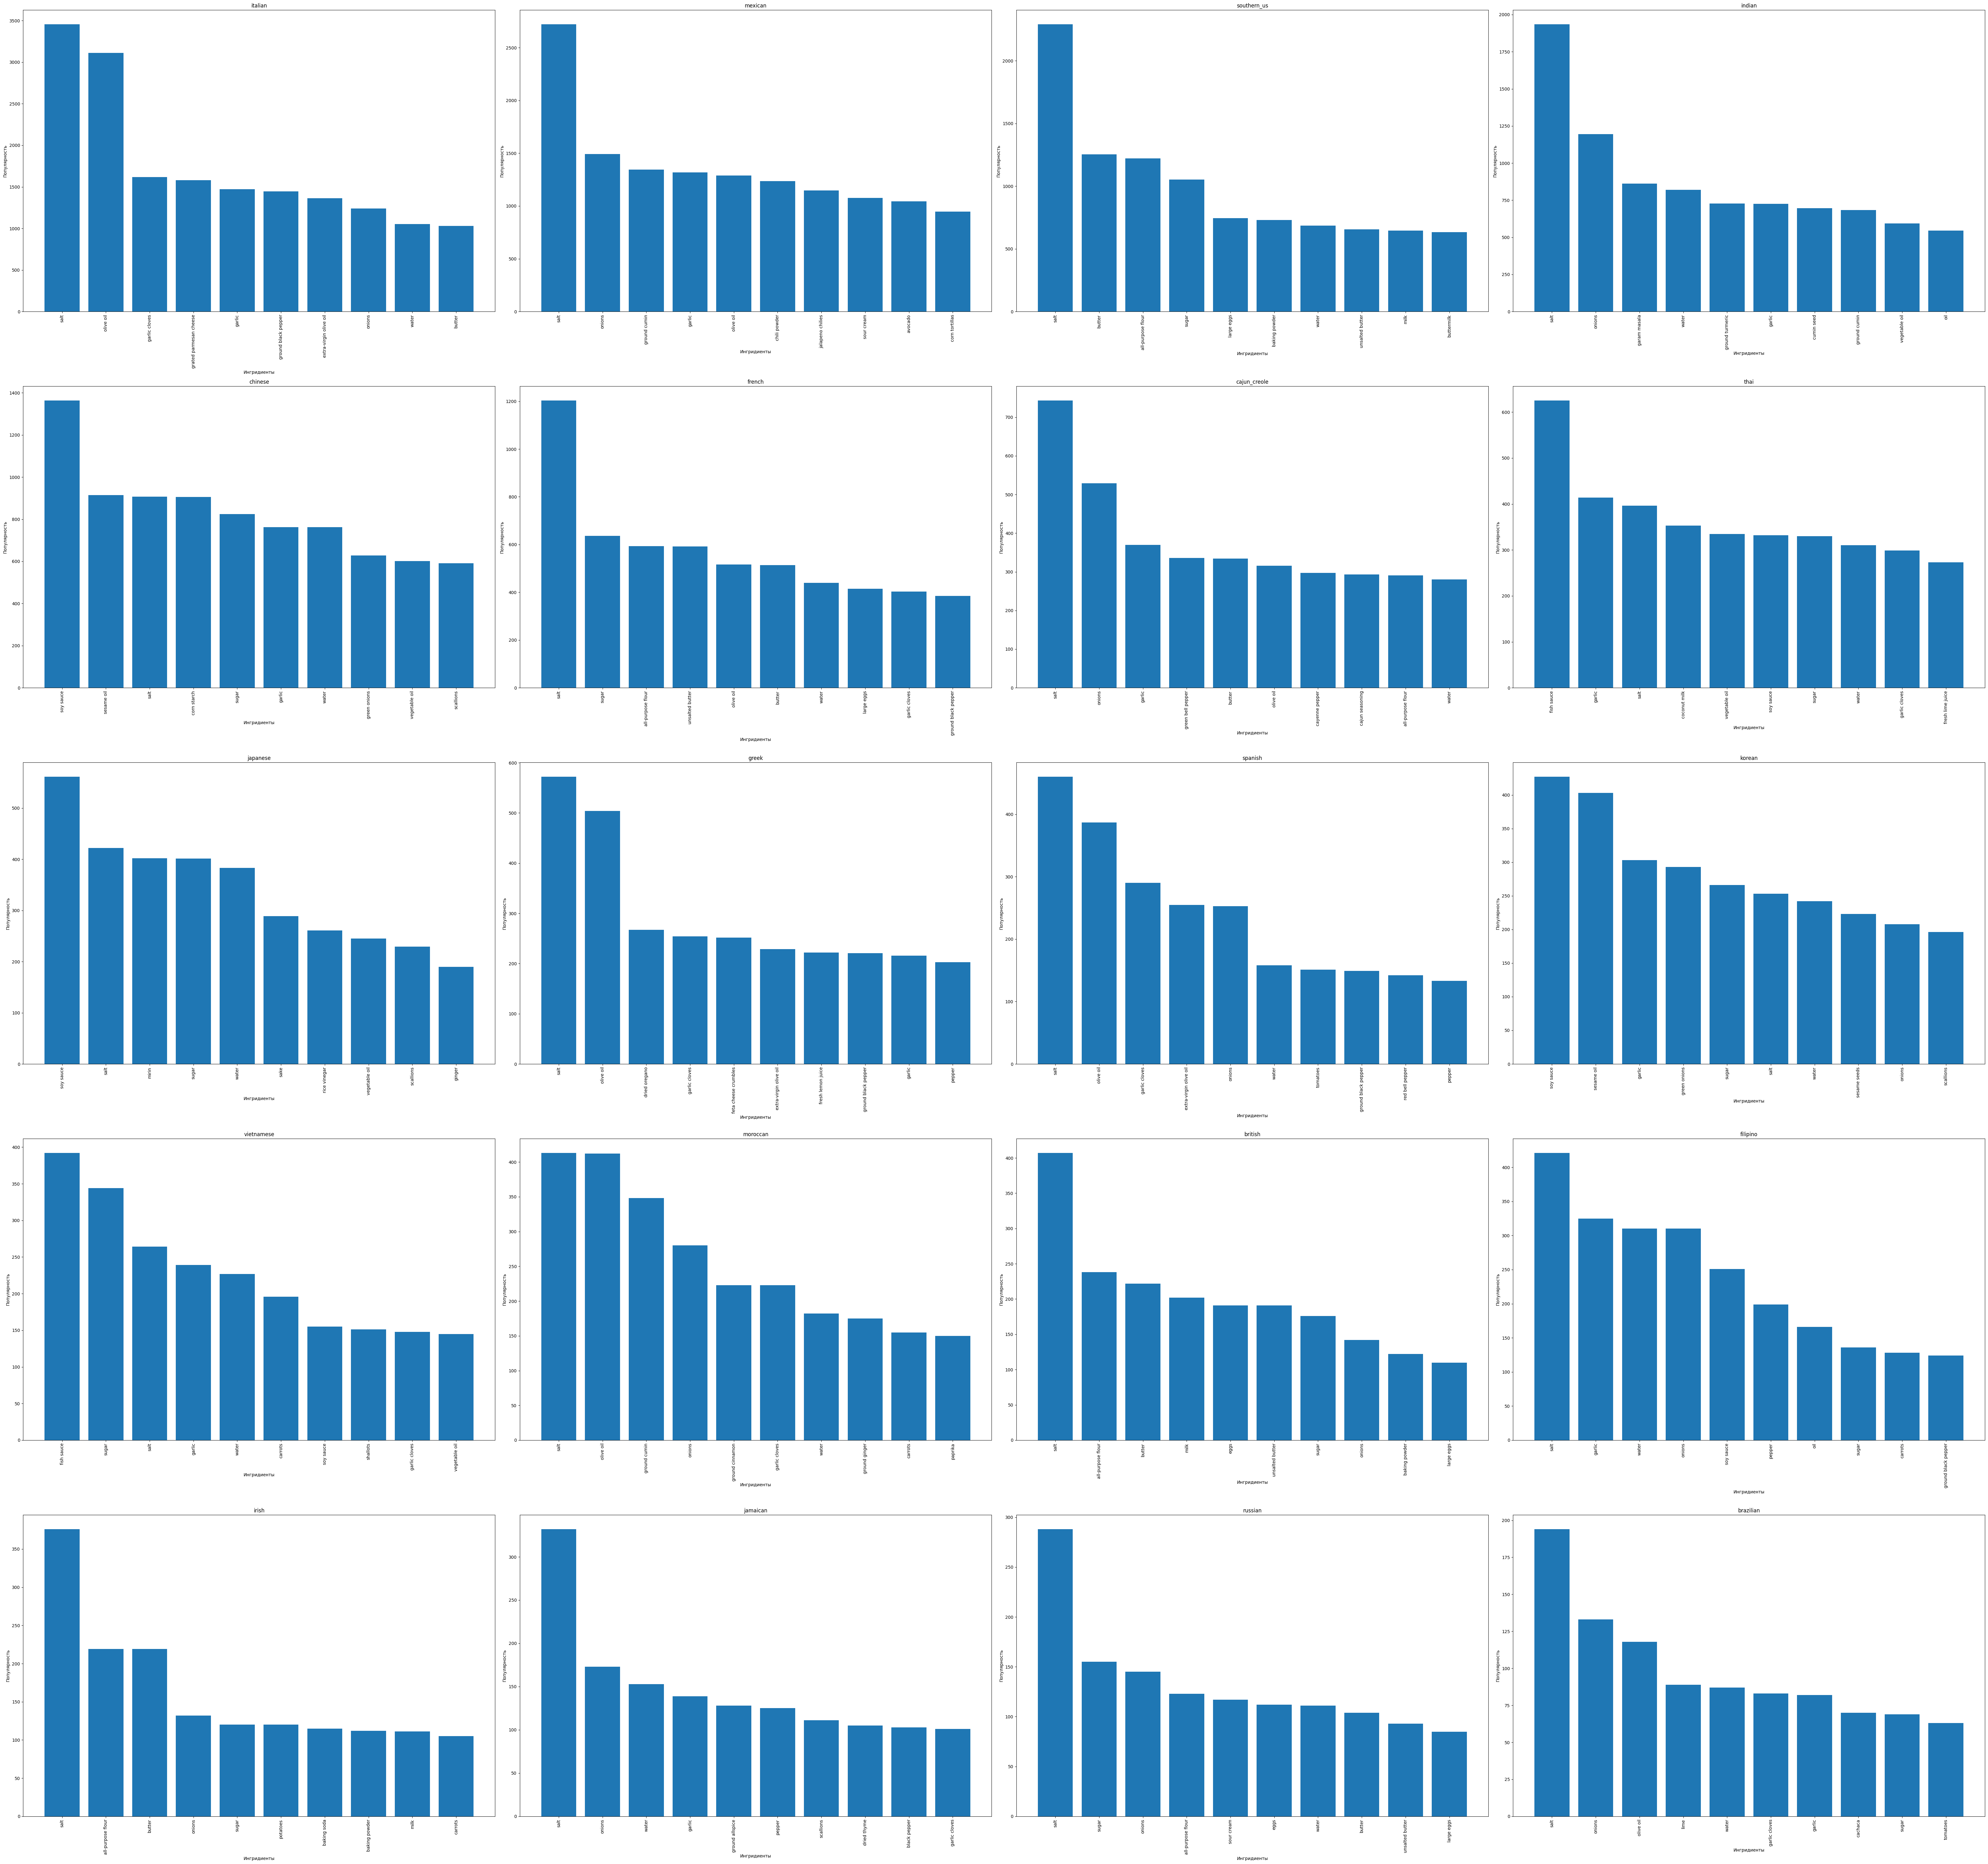

In [ ]:
data_for_hist = {cuisine:dict(sorted(my_dict[cuisine].items(), key=lambda item: item[1], reverse=True)[:10]) for cuisine in my_dict}

fig, axs = plt.subplots(5, 4, figsize=(64, 60))

keys = list(data_for_hist.keys())

for i in range(5):
    for j in range(4):
        if keys:
            key = keys.pop(0)
            value = data_for_hist[key]
            current_keys = list(value.keys())
            current_values = list(value.values())
            axs[i, j].bar(current_keys, current_values)
            axs[i, j].set_title(key)
            axs[i, j].set_xlabel('Ингридиенты')
            axs[i, j].set_ylabel('Популярность')
            axs[i, j].tick_params(axis='x', labelrotation=90)


plt.tight_layout()
plt.show()

Несмотря на проделанный анализ, непонятно, как подступиться к задаче с имеющимися данными

Как вариант, можно добавить в датасет новые признаки-индикаторы на каждый из ингридиентов. Значение будет равно 1, если ингридиент есть в блюде и 0 в иных случаях


In [ ]:
all_ingredients = []
for element in data['ingredients'].values:
    all_ingredients.extend(element)
all_ingredients = list(set(all_ingredients))

In [ ]:
another_data = np.zeros([shape[0], len(all_ingredients)])
data_1 = pd.DataFrame(data=another_data,
          columns=all_ingredients)
data = pd.concat([data, data_1], axis=1)

In [ ]:
for i, element in enumerate(data['ingredients']):
    for ingredient in element:
        data.loc[i, ingredient] = 1

Поделим данные на обучающую и тестовую выборку так, чтобы 70% попало на обучение и 30% на проверку

In [ ]:
labels = data['cuisine']
data = data.drop(columns=['id', 'ingredients', 'cuisine'])
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.3, random_state=42)

Осталось только применить модели машинного обучения и посмотреть на результат
Для начала попробуем метод К ближайших соседей, перебрав значения гиперпараметра k

In [ ]:
clf_neighbors = KNeighborsClassifier(n_neighbors = 3, n_jobs = -1)
clf_neighbors.fit(X_train.values, y_train.values)
y_pred = clf_neighbors.predict(X_test)
accuracy_score(y_pred, y_test)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


0.4601525182267661

А также попробуем классическую логистическую регрессию

In [ ]:
clf = LogisticRegression(n_jobs=-1)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy_score(y_pred, y_test)

0.775412721025727

По результатам логистическая регрессия превзошла KNN с k=3. К сожалению, ресурсов компьютера не хватает, чтобы перебрать параметр количества близких соседей